# Classificação de Gênero Musical

### 1. Problema a ser resolvido
Classificação de gênero musical: 
1. Utilizando Dados extraídos dos espectogramas das musicas
2. Utilizando as próprias imagens dos espectogramas


### 2. Dataset
#### GTZAN dataset

10 Gêneros Musicais
1. Blues
2. Classical
3. Country
4. Disco
5. Hiphop
6. Jazz
7. Metal
8. Pop
9. Reggae
10. Rock


Cada gênero contém 100 musicas. Total dataset: 1000 musicas. (1.2 GB)
Para cada música foi criado uma imagem do espectograma equivalente da musica. (276.6MB)
Para a extração de dados do espectograma foram selecionados as principais                                 features de extração da biblioteca Librosa, que são:

1. Mel-frequency cepstral coefficients (20 coeficientes):
Representação de um conjunto dos espectros de potência de cada faixa de um som
2. Spectral Centroid:
Medida de processamento digital de sinais para caracterizar um espectro. Indica onde está localizado o "centro de massa" do espectro. 
3. Zero Crossing Rate:
Taxa de mudanças de sinal ao longo de um sinal, ou seja, a taxa na qual o sinal muda de positivo para zero para negativo ou de negativo a zero a positivo.
4. Chroma Frequencies:
Medida que abstrai os sinais detectados e os aproximam das classes de notas harmônicas
5. Spectral Roll-off:
Medida que utiliza uma função da frequência logarítmica com as unidades representadas como decibéis ao longo das faixas.


### 3. Trabalhos com o mesmo dataset e mesmo pré processamento
1. https://medium.com/@navdeepsingh_2336/identifying-the-genre-of-a-song-with-neural-networks-851db89c42f0 52,5% acurácia RN 25 features
2. https://gist.github.com/parulnith/7f8c174e6ac099e86f0495d3d9a4c01e 63% acurácia RN 25 features

### 4. Trabalhos com mesmo dataset e preprocessamento mais detalhado
1. https://github.com/Hguimaraes/gtzan.keras 86.4% CNN com 74 features
2. https://github.com/jsalbert/Music-Genre-Classification-with-Deep-Learning CNN + transfer learning + RNN  80%


In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv


import warnings
warnings.filterwarnings('ignore')

### Criando o espectograma a partir dos audios

In [2]:
%%time
#Mapa de calor do spec
cmap = plt.get_cmap('plasma')
#Tamanho da figura resultante
plt.figure(figsize=(12,12))

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
#Criando a pasta de cada diretorio pra suas imagens
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    #Buscando no diretorio dos audios e fazendo a criação do espectograma
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=10)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

CPU times: user 28min 34s, sys: 8.45 s, total: 28min 43s
Wall time: 8min 45s


<Figure size 864x864 with 0 Axes>

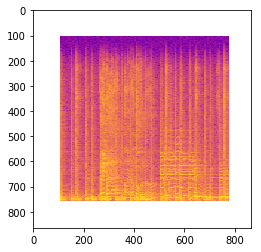

In [3]:
import cv2
imgSpec = cv2.imread('img_data/blues/blues00001.png')
imgSpec = cv2.cvtColor(imgSpec, cv2.COLOR_BGR2RGB)
plt.imshow(imgSpec); plt.show()

### Criando um .csv, a partir dos espectogramas utilizando as features escolhidas

In [79]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [5]:
%%time
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

CPU times: user 57min 11s, sys: 1min 40s, total: 58min 51s
Wall time: 20min 58s


### Analise Exploratória dos dados

In [114]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00013.au,0.264616,1324.304356,1827.737535,2710.033613,0.051417,-209.789266,124.458449,10.310380,47.018006,...,-2.205935,-3.038192,8.645516,-0.304230,-0.637744,-2.939885,-1.705923,-1.769590,-7.762958,blues
1,blues.00044.au,0.390212,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922406,-8.607986,64.494557,...,11.087480,-5.085794,3.976359,-12.859741,12.343857,0.026217,-0.741570,-5.126619,3.303441,blues
2,blues.00018.au,0.269929,1537.657183,2054.779113,3495.653862,0.056132,-252.533986,104.927485,15.353578,42.656638,...,1.960557,-0.881435,7.778604,2.390255,1.774140,1.339317,3.630699,4.910860,-2.651944,blues
3,blues.00028.au,0.275974,1115.729116,1398.954704,2290.444483,0.048028,-248.967653,139.038459,-16.249238,57.098117,...,-2.844094,-0.893325,-2.401651,2.572721,-5.873962,-12.408275,-7.301892,-0.932405,-2.699273,blues
4,blues.00076.au,0.365575,2645.681661,2426.198512,5612.507729,0.136469,-52.693061,74.430284,-18.692437,56.323873,...,7.792499,-10.561926,6.946956,-9.127867,13.020091,-9.854002,3.689460,-4.947726,4.426066,blues


In [4]:
data.columns

Index(['filename', 'chroma_stft', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'label'],
      dtype='object')

In [5]:
data.tail()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
995,rock.00058.au,0.301092,2437.399429,2789.821383,5497.725089,0.098943,-141.984890,96.997318,23.241800,10.453830,...,-2.016179,-5.892612,-6.021554,-2.120564,-6.166340,-0.326774,5.096092,0.124513,1.674481,rock
996,rock.00090.au,0.255691,2495.737423,2249.869714,5213.168477,0.120643,-89.024086,86.200578,-24.400166,47.094960,...,7.481489,-12.851751,8.588623,-7.891173,11.490477,0.681784,9.796061,-2.127682,0.589409,rock
997,rock.00071.au,0.454292,2025.045157,2215.382497,4571.205692,0.090808,-79.809090,109.923227,-17.112701,47.178773,...,13.030406,-11.579700,9.104020,-5.953490,4.914147,-8.710204,3.701960,-5.099721,2.622137,rock
998,rock.00034.au,0.421082,2789.712144,2648.716877,5836.164710,0.135008,-28.061826,65.631668,-7.352339,33.593664,...,3.189335,-1.685570,-0.161785,-1.691113,1.850430,-3.969524,-1.626862,-6.389011,-3.863663,rock
999,rock.00072.au,0.403287,1933.518476,2211.281522,4359.906970,0.081729,-95.307878,112.446491,-2.083334,47.050788,...,11.874564,-11.191177,8.876775,-4.945704,0.924623,-6.106566,3.237717,-8.072705,0.733370,rock


In [6]:
data.shape

(1000, 27)

In [7]:
data.describe()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378669,2201.834226,2242.559613,4571.702159,0.103637,-144.479173,99.552199,-8.921949,36.293063,-1.146627,...,-6.021121,4.471604,-4.797232,1.781547,-3.870275,1.147988,-3.967431,0.507303,-2.328779,-1.094875
std,0.081706,715.961347,526.337663,1574.770035,0.041834,100.235661,31.331904,21.695015,16.666987,12.222555,...,6.819018,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561
min,0.171782,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,-89.901142,-18.768461,-38.903451,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,0.319641,1627.793931,1907.136505,3380.956639,0.070281,-200.695133,76.811480,-24.223791,24.107395,-9.974552,...,-10.966826,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194297,-2.003979,-4.670281,-3.368000
50%,0.383075,2209.468780,2221.408983,4658.671830,0.099539,-120.206072,98.452551,-10.716073,36.957074,-0.015239,...,-5.920161,3.891842,-4.199810,1.879424,-3.614473,1.211944,-4.059109,0.669788,-2.391261,-1.155198
75%,0.435974,2691.969702,2578.474352,5534.197785,0.132007,-73.895019,119.893638,5.505793,48.212826,7.920911,...,-1.004241,9.706133,-0.161017,5.155264,-0.323536,4.350694,-0.842968,3.112518,0.149070,1.303739
max,0.663573,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,56.666090,80.691273,31.461661,...,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


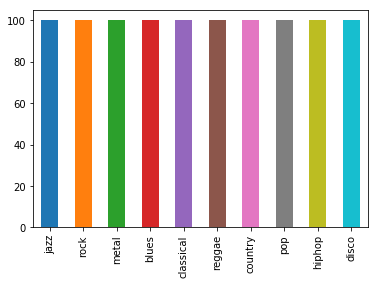

In [8]:
data['label'].value_counts().plot(kind='bar');

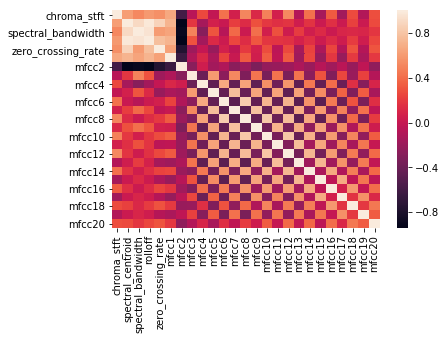

In [9]:
import seaborn as sns
sns.heatmap(data.corr())
sns.set_style("whitegrid")
plt.show()

### Novo DF sem a coluna filename

In [115]:
dataFinal = data.drop("filename", axis=1)
dataFinal.target_name="label"

In [13]:
dataFinal.head()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.264616,1324.304356,1827.737535,2710.033613,0.051417,-209.789266,124.458449,10.310380,47.018006,6.510238,...,-2.205935,-3.038192,8.645516,-0.304230,-0.637744,-2.939885,-1.705923,-1.769590,-7.762958,blues
1,0.390212,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922406,-8.607986,64.494557,-6.304126,...,11.087480,-5.085794,3.976359,-12.859741,12.343857,0.026217,-0.741570,-5.126619,3.303441,blues
2,0.269929,1537.657183,2054.779113,3495.653862,0.056132,-252.533986,104.927485,15.353578,42.656638,6.778399,...,1.960557,-0.881435,7.778604,2.390255,1.774140,1.339317,3.630699,4.910860,-2.651944,blues
3,0.275974,1115.729116,1398.954704,2290.444483,0.048028,-248.967653,139.038459,-16.249238,57.098117,20.196359,...,-2.844094,-0.893325,-2.401651,2.572721,-5.873962,-12.408275,-7.301892,-0.932405,-2.699273,blues
4,0.365575,2645.681661,2426.198512,5612.507729,0.136469,-52.693061,74.430284,-18.692437,56.323873,-3.939688,...,7.792499,-10.561926,6.946956,-9.127867,13.020091,-9.854002,3.689460,-4.947726,4.426066,blues


## Classificação de gênero musical

### Passos de experimentação
1. Modelos de algorítimos
    1. Perceptron, SGDClassifier, LogisticRegression, KNeighborsClassifier, GaussianNB, SVC, LinearSVC, DecisionTreeClassifier, XGBClassifier
2. Tipos de dados
    1. Dados brutos
    2. Dados standardizados
    3. Kfold e Cross validation
3. Deep Learning
    1. Rede neural profunda com dataset de features extraídas dos spectograma
    2. Rede neural convolucional com imagens dos espectogramas

In [121]:
#imports

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#crosvall
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

#metrics
from sklearn.metrics import accuracy_score as acc

### Aplicando labelencoder e separando features x label

In [116]:
X = dataFinal.drop(['label'], axis=1)
y = dataFinal[['label']]

### Dividindo dataset 80% treino e 20% teste

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42, 
                                                    stratify=y,shuffle=True)

In [118]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(x_train)
X_test_std = scaler.transform(x_test)

### Classificadores

In [122]:
Per = Perceptron()
SGD = SGDClassifier()
Log = LogisticRegression()
KNN = KNeighborsClassifier()
Gau = GaussianNB()
SVC = SVC() 
LinearSVC = LinearSVC()
DTC = DecisionTreeClassifier()
xgboostingCLF = xgb.XGBClassifier()


classifiers = [Per, SGD, Log, KNN, Gau, SVC, LinearSVC, DTC, xgboostingCLF]
classifiersNames = ['Perceptron', 'SGD', 'LogisticRegression', 'KNN', 'GaussianNB', 'SVC', 'LinearSVC', 'DecisionTreeClassifier', 'XGBoost']

### Acurácia de cada modelo com dados normais

In [123]:
warnings.simplefilter('ignore')

results1 = []

a = 0
for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    results1.append(acc(y_pred, y_test))
    print(classifiersNames[a],' : ', acc(y_pred, y_test))
    a = a + 1

Perceptron  :  0.11
SGD  :  0.25
LogisticRegression  :  0.545
KNN  :  0.355
GaussianNB  :  0.42
SVC  :  0.115
LinearSVC  :  0.185
DecisionTreeClassifier  :  0.475
XGBoost  :  0.595


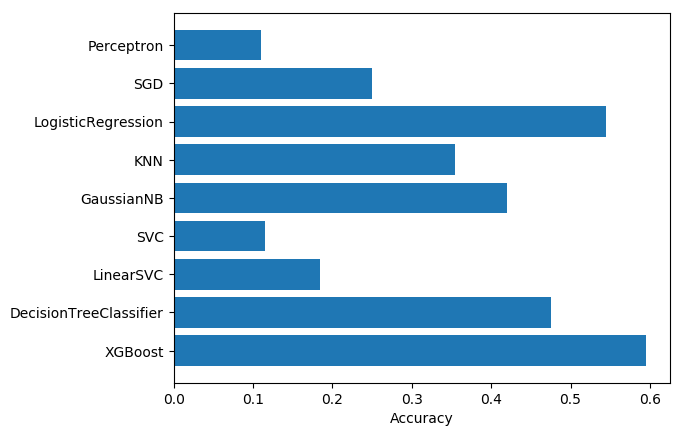

In [124]:
def makeGraph(result):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    # Example data
    class_names = [i for i in classifiersNames]
    y_pos = np.arange(len(class_names))

    ax.barh(y_pos, result, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Accuracy')

    return plt.show()

makeGraph(results1)

### Acurácia de cada modelo com dados standardizados

In [125]:
warnings.simplefilter('ignore')

results2 = []

a = 0
for clf in classifiers:
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict(X_test_std)
    results2.append(acc(y_pred, y_test))
    print(classifiersNames[a],' : ', acc(y_pred, y_test))
    a = a + 1

Perceptron  :  0.395
SGD  :  0.515
LogisticRegression  :  0.6
KNN  :  0.635
GaussianNB  :  0.43
SVC  :  0.65
LinearSVC  :  0.62
DecisionTreeClassifier  :  0.485
XGBoost  :  0.595


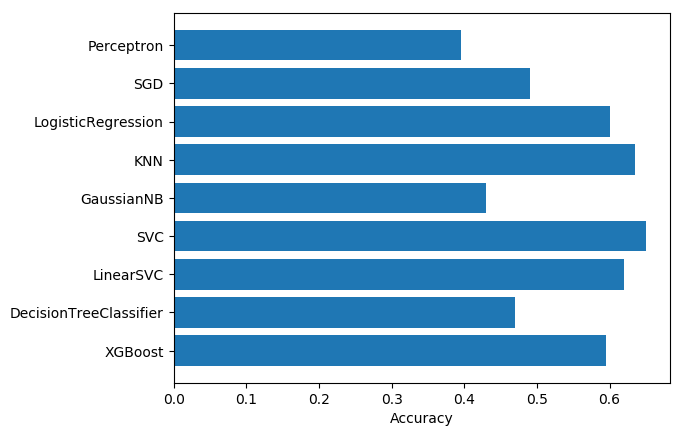

In [22]:
makeGraph(results2)

### Acurácia de cada modelo com KFold e Cross Validation

In [126]:
warnings.simplefilter('ignore')

cv = KFold(n_splits=3, shuffle=True, random_state=42)
results3 = []

a = 0
for i in classifiers:
    pipeline = Pipeline([('transformer', scaler), ('estimator', i)])
    acc = cross_val_score(pipeline, np.float64(X), y, cv=cv, scoring='accuracy')
    results3.append(np.mean(acc))
    print(classifiersNames[a],' : ',np.mean(acc))
    a = a + 1

Perceptron  :  0.4449779120437803
SGD  :  0.4960349571128015
LogisticRegression  :  0.5970401539263814
KNN  :  0.5750061438684193
GaussianNB  :  0.413011814209419
SVC  :  0.6510282737827647
LinearSVC  :  0.6130381878884873
DecisionTreeClassifier  :  0.43298388208567845
XGBoost  :  0.5880071688454921


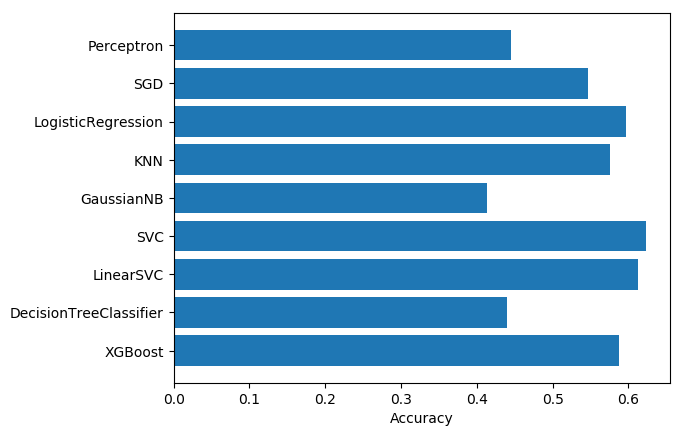

In [24]:
makeGraph(results3)

### Média da acurácia dos modelos nos cenários experimentados

In [127]:
def medias(l1,l2,l3):
    medias = []
    
    for i in range(9):
        medias.append((l1[i]+l2[i]+l3[i])/3)
    
    return medias

dfMedias = pd.DataFrame ({
    'Classificadores' : classifiersNames,
    'Cenário 1': results1,
    'Cenário 2': results2,
    'Cenário 3': results3,
    'Medias': medias(results1, results2, results3)
})

In [128]:
dfMedias = dfMedias.sort_values('Medias', ascending=False)
dfMedias

,Classificadores,Cenário 1,Cenário 2,Cenário 3,Medias
8,XGBoost,0.595,0.595,0.588007,0.592669
2,LogisticRegression,0.545,0.600,0.597040,0.580680
3,KNN,0.355,0.635,0.575006,0.521669
6,LinearSVC,0.185,0.620,0.613038,0.472679
5,SVC,0.115,0.650,0.651028,0.472009
7,DecisionTreeClassifier,0.475,0.485,0.432984,0.464328
4,GaussianNB,0.420,0.430,0.413012,0.421004
1,SGD,0.250,0.515,0.496035,0.420345
0,Perceptron,0.110,0.395,0.444978,0.316659


### GridSearch dos 2 melhores modelos

In [28]:
from sklearn.model_selection import GridSearchCV
import numpy as np 

from sklearn.linear_model import LogisticRegression
import xgboost

In [29]:
warnings.simplefilter('ignore')

logreg=LogisticRegression()
grid={"multi_class" : ["ovr","multinomial"], "verbose" : [0,1], 
      "max_iter" : [100,1000], "solver":["saga","lbfgs"],"random_state":[13,42]}
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_train_std,y_train)

print("Melhores hiperparametros: ",logreg_cv.best_params_)
print("Acurácia: ",logreg_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 241 epochs took 0 seconds
convergence after 254 epochs took 0 seconds
convergence after 183 epochs took 0 seconds
convergence after 233 epochs took 0 seconds
convergence after 165 epochs took 0 seconds
convergence after 151 epochs took 0 seconds
convergence after 230 epochs took 0 seconds
convergence after 289 epochs took 0 seconds
convergence after 194 epochs took 0 seconds
convergence after 220 epochs took 0 seconds
convergence after 206 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 198 epochs took 0 seconds
convergence after 175 epochs took 1 seconds
convergence after 221 epochs took 0 seconds
convergence after 147 epochs took 0 seconds
convergence after 155 epochs took 0 seconds
convergence after 239 epochs took 0 seconds
convergence after 346 epochs took 0 seconds
convergence after 202 epochs took 0 seconds
convergence after 204 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 236 epochs took 0 seconds
convergence after 233 epochs took 0 seconds
convergence after 121 epochs took 0 seconds
convergence after 210 epochs took 1 seconds
convergence after 156 epochs took 0 seconds
convergence after 138 epochs took 0 seconds
convergence after 236 epochs took 0 seconds
convergence after 290 epochs took 0 seconds
convergence after 227 epochs took 0 seconds
convergence after 222 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 243 epochs took 0 seconds
convergence after 255 epochs took 0 seconds
convergence after 181 epochs took 0 seconds
convergence after 236 epochs took 0 seconds
convergence after 162 epochs took 0 seconds
convergence after 149 epochs took 0 seconds
convergence after 232 epochs took 0 seconds
convergence after 290 epochs took 0 seconds
convergence after 190 epochs took 0 seconds
convergence after 222 epochs took 0 seconds
convergence after 205 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 198 epochs took 0 seconds
convergence after 172 epochs took 0 seconds
convergence after 222 epochs took 0 seconds
convergence after 146 epochs took 0 seconds
convergence after 155 epochs took 0 seconds
convergence after 240 epochs took 0 seconds
convergence after 345 epochs took 1 seconds
convergence after 205 epochs took 0 seconds
convergence after 205 epochs took 0 seconds
convergence after 234 epochs took 0 seconds
convergence after 236 epochs took 0 seconds
convergence after 122 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 209 epochs took 0 seconds
convergence after 155 epochs took 0 seconds
convergence after 135 epochs took 0 seconds
convergence after 237 epochs took 0 seconds
convergence after 290 epochs took 0 seconds
convergence after 227 epochs took 0 seconds
convergence after 221 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 266 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 347 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 249 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 263 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 344 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 251 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Melhores hiperparametros:  {'max_iter': 100, 'multi_class': 'multinomial', 'random_state': 13, 'solver': 'saga', 'verbose': 0}
Acurácia:  0.635


In [30]:
xgb = xgboost.XGBClassifier()
grid={"learning_rate" : [0.1, 0.05, 0.01] ,"n_estimators" : [50, 100, 200], 
      "max_depth" : [3, 5, 7], "objective" : ["multi:softmax"]}
xgb_cv=GridSearchCV(xgb,grid,cv=3)
xgb_cv.fit(X_train_std,y_train)

print("Melhores hiperparametros: ",xgb_cv.best_params_)
print("Acurácia :",xgb_cv.best_score_)

Melhores hiperparametros:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'multi:softmax'}
Acurácia : 0.6125


### Classification report do melhor modelo

In [31]:
from sklearn.metrics import classification_report

In [32]:
bestModel = LogisticRegression(max_iter=100, multi_class="multinomial", solver="saga", verbose=0)
bestModel.fit(X_train_std,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
bestModelPred = bestModel.predict(X_test_std)

In [34]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [35]:
trues = np.array(list(y_test['label']))

In [36]:
print(classification_report(list(trues), list(bestModelPred), target_names=genres))

              precision    recall  f1-score   support

       blues       0.72      0.65      0.68        20
   classical       0.95      1.00      0.98        20
     country       0.48      0.50      0.49        20
       disco       0.43      0.45      0.44        20
      hiphop       0.60      0.60      0.60        20
        jazz       0.71      0.60      0.65        20
       metal       0.89      0.80      0.84        20
         pop       0.60      0.75      0.67        20
      reggae       0.48      0.50      0.49        20
        rock       0.33      0.30      0.32        20

   micro avg       0.61      0.61      0.61       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200



In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()

In [38]:
cm = confusion_matrix(trues, bestModelPred)

Confusion matrix
[[13  0  0  2  0  1  0  0  0  4]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 1  0 10  1  0  1  0  2  2  3]
 [ 0  1  1  9  3  0  0  2  1  3]
 [ 0  0  0  2 12  0  0  2  4  0]
 [ 1  0  5  0  0 12  0  1  1  0]
 [ 0  0  0  2  0  0 16  0  1  1]
 [ 0  0  1  2  1  1  0 15  0  0]
 [ 1  0  1  1  3  2  0  1 10  1]
 [ 2  0  3  2  1  0  2  2  2  6]]


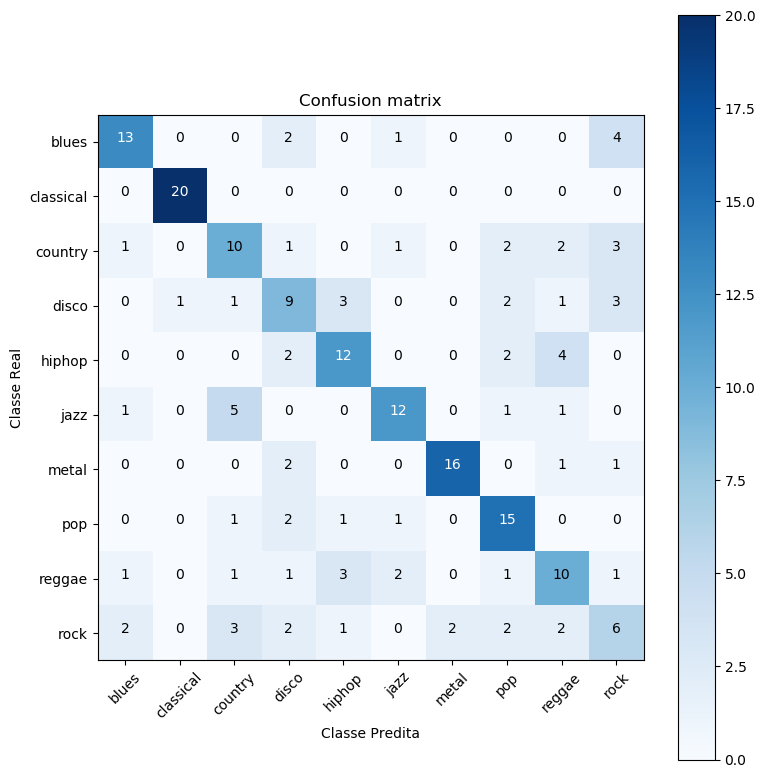

In [39]:
plot_confusion_matrix(cm, classes=genres,
                      title='Confusion matrix')

## Deep Learning

### Recarregando os dados

In [42]:
data = data.drop(['filename'],axis=1)

In [43]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 25), (200, 25), (800,), (200,))

### Estrutura de uma Rede profunda
<img src="files/rp.png">

In [99]:
from keras import models
from keras import layers
from keras.layers import Dropout

In [100]:
inputLayer = X_train.shape[1]

In [107]:
model = models.Sequential()
## input layer has 25 features
model.add(layers.Dense(512, activation='relu', input_shape=(inputLayer,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [108]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [109]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32)

Epoch 1/50
800/800 [==============================] - 1s 1ms/step - loss: 1.8383 - acc: 0.3375
Epoch 2/50
800/800 [==============================] - 0s 108us/step - loss: 1.3063 - acc: 0.5162
Epoch 3/50
800/800 [==============================] - 0s 112us/step - loss: 1.1214 - acc: 0.5900
Epoch 4/50
800/800 [==============================] - 0s 106us/step - loss: 0.9461 - acc: 0.6737
Epoch 5/50
800/800 [==============================] - 0s 111us/step - loss: 0.8256 - acc: 0.7150
Epoch 6/50
800/800 [==============================] - 0s 126us/step - loss: 0.7533 - acc: 0.7450
Epoch 7/50
800/800 [==============================] - 0s 116us/step - loss: 0.6504 - acc: 0.7850
Epoch 8/50
800/800 [==============================] - 0s 125us/step - loss: 0.5584 - acc: 0.8150
Epoch 9/50
800/800 [==============================] - 0s 115us/step - loss: 0.5023 - acc: 0.8463
Epoch 10/50
800/800 [==============================] - 0s 111us/step - loss: 0.4371 - acc: 0.8600
Epoch 11/50
800/800 [==========

In [110]:
test_loss, test_acc = model.evaluate(X_test,y_test)

200/200 [==============================] - 0s 1ms/step


In [111]:
print('Log loss: ', test_loss, 'Acurácia: ', test_acc)

Log loss:  1.8785823249816895 Acurácia:  0.68


### Conjunto de validação

In [94]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [95]:
model = models.Sequential()
#model.add(Dropout(0.25, input_shape=(25,)))
model.add(layers.Dense(1024, activation='relu', input_shape=(inputLayer,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=50,
          batch_size=32,
          validation_data=(x_val, y_val))

results = model.evaluate(X_test, y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/50
600/600 [==============================] - 1s 2ms/step - loss: 1.8207 - acc: 0.3600 - val_loss: 1.5479 - val_acc: 0.4400
Epoch 2/50
600/600 [==============================] - 0s 331us/step - loss: 1.3167 - acc: 0.5350 - val_loss: 1.3376 - val_acc: 0.5100
Epoch 3/50
600/600 [==============================] - 0s 353us/step - loss: 1.1308 - acc: 0.5833 - val_loss: 1.2726 - val_acc: 0.5600
Epoch 4/50
600/600 [==============================] - 0s 348us/step - loss: 0.9451 - acc: 0.6850 - val_loss: 1.1800 - val_acc: 0.5750
Epoch 5/50
600/600 [==============================] - 0s 351us/step - loss: 0.8078 - acc: 0.7100 - val_loss: 1.3531 - val_acc: 0.5300
Epoch 6/50
600/600 [==============================] - 0s 337us/step - loss: 0.7269 - acc: 0.7183 - val_loss: 1.2864 - val_acc: 0.5800
Epoch 7/50
600/600 [==============================] - 0s 333us/step - loss: 0.6731 - acc: 0.7583 - val_loss: 1.2925 - val_acc: 0.6100
Epoch 8/50
600/600

In [96]:
print("Log loss: ", results[0]," Acurácia: ", results[1])

Log loss:  2.250120162963867  Acurácia:  0.67


### Convolutional Neural Network
<img src="files/conv.png">